In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.orm import sessionmaker

In [3]:
db_name = "ethprice"
db_host = "localhost"
db_username = "root"
db_password = "Coolio.io9A"


engine = create_engine(f"mysql+pymysql://{db_username}:{db_password}@{db_host}/{db_name}")
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
eth_stock = pd.read_csv("/Users/aaminathasneemkhaleel/Downloads/ETH-USD.csv")

In [5]:
eth_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09


In [7]:
print(eth_stock .isnull().sum())
#there is a null value for each which could potentially impact results
null_rows = eth_stock[eth_stock.isnull().any(axis=1)]
print(null_rows)
eth_stock=eth_stock.dropna()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
            Date  Open  High  Low  Close  Adj Close  Volume
2663  2025-02-23   NaN   NaN  NaN    NaN        NaN     NaN


In [8]:
# after dropping null value
print(eth_stock .isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# preliminary analysis stage 1 --> compute summary statistics
summary_stats = {
    "Mean Open": np.mean(eth_stock["Open"]),
    "Median Open": np.median(eth_stock["Open"]),
    "Std. Deviation Open": np.std(eth_stock["Open"]),
    
     "Mean High": np.mean(eth_stock["High"]),
    "Median High": np.median(eth_stock["High"]),
    "Std. Deviation High": np.std(eth_stock["High"]),
    
     "Mean Low": np.mean(eth_stock["Low"]),
    "Median Low": np.median(eth_stock["Low"]),
    "Std. Deviation Low": np.std(eth_stock["Low"]),
    
     "Mean Close": np.mean(eth_stock["Close"]),
    "Median Close": np.median(eth_stock["Close"]),
    "Std. Deviation Close": np.std(eth_stock["Close"]),
    
    "Average Volume": np.mean(eth_stock["Volume"]),
    "Highest Closing Price": np.max(eth_stock["Close"]),
    "Lowest Closing Price": np.min(eth_stock["Close"])
}

summary_df = pd.DataFrame(summary_stats, index=[0])

print(summary_df)

     Mean Open  Median Open  Std. Deviation Open    Mean High  Median High  \
0  1522.818337  1465.419311          1235.287101  1564.434018  1542.162842   

   Std. Deviation High     Mean Low   Median Low  Std. Deviation Low  \
0          1268.019253  1477.121089  1423.441834         1198.562736   

    Mean Close  Median Close  Std. Deviation Close  Average Volume  \
0  1523.560701    1470.71759           1235.022177    1.328927e+10   

   Highest Closing Price  Lowest Closing Price  
0            4812.087402             84.308296  


In [10]:
#volatility analysis
eth_stock["Volatility_7d"] = eth_stock["Close"].rolling(window=7).std()
eth_stock["Volatility_30d"] = eth_stock["Close"].rolling(window=30).std()


 # Defined a threshold (trying to identify periods of high volatility) --> compare this to the blockchain transaction data
volatility_threshold = eth_stock["Volatility_30d"].mean() 
high_volatility_periods = eth_stock[eth_stock["Volatility_30d"] > volatility_threshold]

print(high_volatility_periods["Date"])

40      2017-12-19
41      2017-12-20
42      2017-12-21
43      2017-12-22
44      2017-12-23
           ...    
2659    2025-02-19
2660    2025-02-20
2661    2025-02-21
2662    2025-02-22
2664    2025-02-24
Name: Date, Length: 1080, dtype: object


In [11]:
# moving average and then will conduct an analysis based on the moviong averages for PoW and PoS
#simple moving average and exponential moving average (for both 7 and 30 days)
eth_stock["SMA_7"] = eth_stock["Close"].rolling(window=7).mean()  
eth_stock["SMA_30"] = eth_stock["Close"].rolling(window=30).mean()

#note to self --> When adjust=False, the exponentially weighted function is calculated recursively

eth_stock["EMA_7"] = eth_stock["Close"].ewm(span=7, adjust=False).mean()
eth_stock["EMA_30"] = eth_stock["Close"].ewm(span=30, adjust=False).mean()



In [12]:
#average trading volume
average_volume = eth_stock["Volume"].mean()
print(f"Average Trading Volume: {average_volume}")

#high trading volume days
high_volume_days = eth_stock[eth_stock["Volume"] > 1.5 * eth_stock["Volume"].mean()]
print(high_volume_days["Date"])


Average Trading Volume: 13289272647.650526
825     2020-02-12
826     2020-02-13
827     2020-02-14
828     2020-02-15
829     2020-02-16
           ...    
2652    2025-02-12
2657    2025-02-17
2658    2025-02-18
2661    2025-02-21
2664    2025-02-24
Name: Date, Length: 531, dtype: object


In [13]:
eth_stock.dtypes

Date               object
Open              float64
High              float64
Low               float64
Close             float64
Adj Close         float64
Volume            float64
Volatility_7d     float64
Volatility_30d    float64
SMA_7             float64
SMA_30            float64
EMA_7             float64
EMA_30            float64
dtype: object

In [14]:
eth_stock["Date"] = pd.to_datetime(eth_stock["Date"])

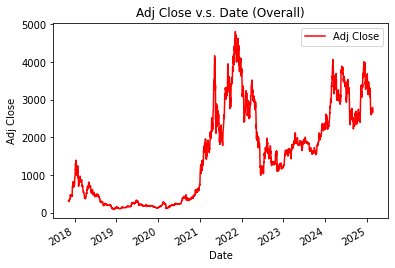

In [15]:
eth_stock.plot(x='Date', y='Adj Close', c='red')
plt.title('Adj Close v.s. Date (Overall)')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

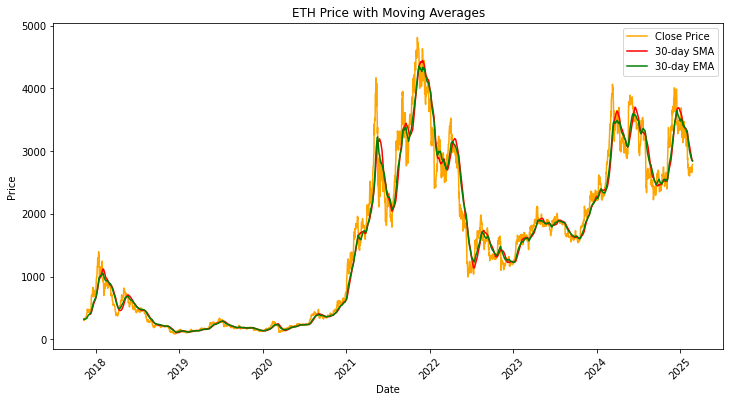

In [16]:
plt.figure(figsize=(12,6))
plt.plot(eth_stock["Date"], eth_stock["Close"], color='orange', label="Close Price")
plt.plot(eth_stock["Date"], eth_stock["SMA_30"], label="30-day SMA", color="red")
plt.plot(eth_stock["Date"], eth_stock["EMA_30"], label="30-day EMA", color="green")

plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("ETH Price with Moving Averages")
plt.show()


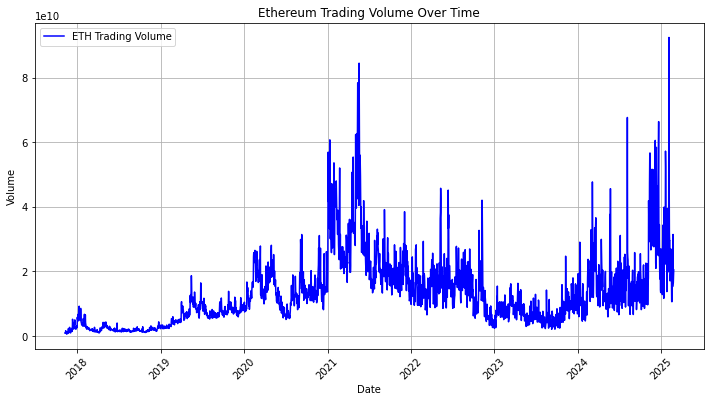

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(eth_stock['Date'], eth_stock['Volume'], linestyle='-', color='b', label="ETH Trading Volume")

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Ethereum Trading Volume Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [17]:
#now will split the date for PoW and PoS
cutoff = pd.to_datetime('2022-09-15')
sec_PoW = eth_stock[pd.to_datetime(eth_stock['Date']) < cutoff]
sec_PoS = eth_stock[pd.to_datetime(eth_stock['Date']) >= cutoff]

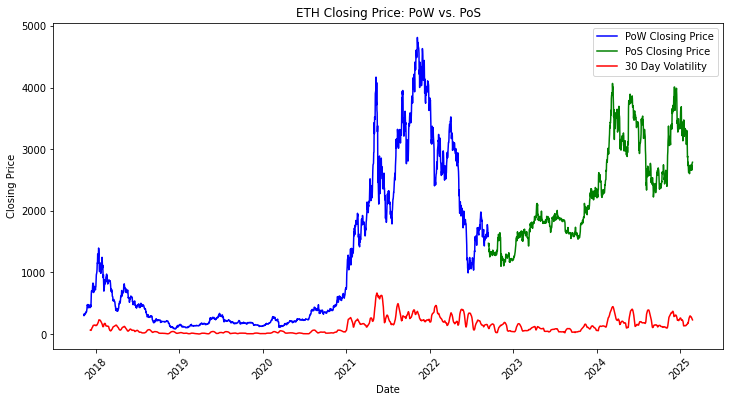

In [18]:
# plotting date and closing price based on PoW and PoS
plt.figure(figsize=(12, 6))
plt.plot(sec_PoW["Date"], sec_PoW["Close"], color='blue', label="PoW Closing Price")

# Plotting date and closing price for PoS
plt.plot(sec_PoS["Date"], sec_PoS["Close"], color='green', label="PoS Closing Price")
plt.plot(eth_stock["Date"], eth_stock["Volatility_30d"], color="red", label = "30 Day Volatility")

plt.title('ETH Closing Price: PoW vs. PoS')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45) 
plt.legend()

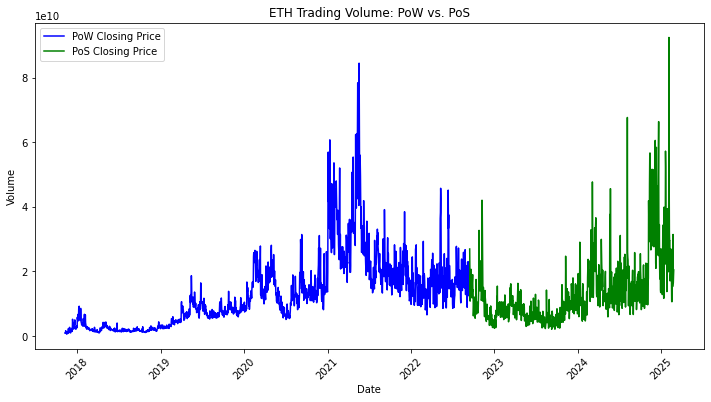

In [30]:
# plotting date and closing price based on PoW and PoS
plt.figure(figsize=(12, 6))
plt.plot(sec_PoW["Date"], sec_PoW["Volume"], color='blue', label="PoW Closing Price")

# Plotting date and closing price for PoS
plt.plot(sec_PoS["Date"], sec_PoS["Volume"], color='green', label="PoS Closing Price")


plt.title('ETH Trading Volume: PoW vs. PoS')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)  
plt.legend()

In [20]:
#decide to backfill data in order to run linear regression test
eth_stock.bfill(limit=31, inplace=True)
eth_stock.head(30)

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility_7d,Volatility_30d,SMA_7,SMA_30,EMA_7,EMA_30
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08,13.495007,64.717254,318.632856,400.082003,320.884003,320.884003
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08,13.495007,64.717254,318.632856,400.082003,315.476250,319.488454
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08,13.495007,64.717254,318.632856,400.082003,315.277438,319.178296
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09,13.495007,64.717254,318.632856,400.082003,313.435076,318.451179
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09,13.495007,64.717254,318.632856,400.082003,314.255307,318.339232
5,2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1.069680e+09,13.495007,64.717254,318.632856,400.082003,320.099234,319.583863
6,2017-11-15,337.963989,340.911987,329.812988,333.356995,333.356995,7.226660e+08,13.495007,64.717254,318.632856,400.082003,323.413674,320.472452
7,2017-11-16,333.442993,336.158997,323.605988,330.924011,330.924011,7.972540e+08,14.284583,64.717254,320.067143,400.082003,325.291258,321.146746
8,2017-11-17,330.166992,334.963989,327.523010,332.394012,332.394012,6.217330e+08,11.446358,64.717254,324.801575,400.082003,327.066947,321.872376
9,2017-11-18,331.980011,349.615997,327.687012,347.612000,347.612000,6.496390e+08,13.222977,64.717254,329.506003,400.082003,332.203210,323.532997


Mean Squared Error: 30065.801427609662


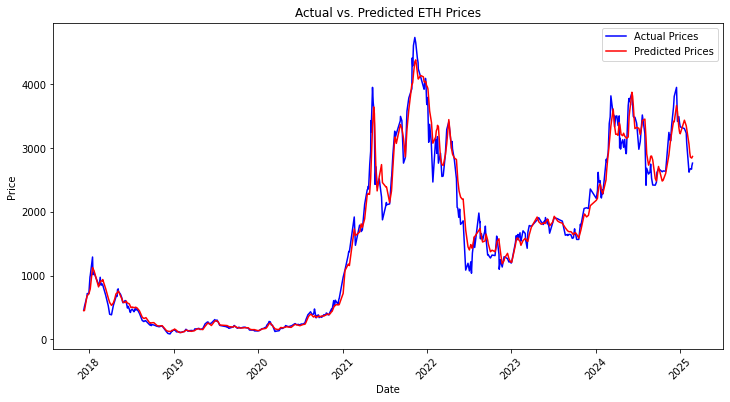

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# eth_stock.set_index("Date", inplace=True)

#forward filling NaN values for each of rhe SMA_30, EMA_30, and Volatility_30d
# eth_stock.fillna(method='ffill', inplace=True)


features = eth_stock[['SMA_30', 'EMA_30', 'Volatility_30d']]
target = eth_stock['Close']
dates = eth_stock['Date']

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(features, target, dates, test_size=0.2, random_state=42)

dates_train = dates_train.sort_values()
dates_test = dates_test.sort_values()
y_train = y_train.loc[dates_train.index]
y_test = y_test.loc[dates_test.index]
X_train = X_train.loc[dates_train.index]
X_test = X_test.loc[dates_test.index]

#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Prices', color='blue')
plt.plot(dates_test, predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted ETH Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

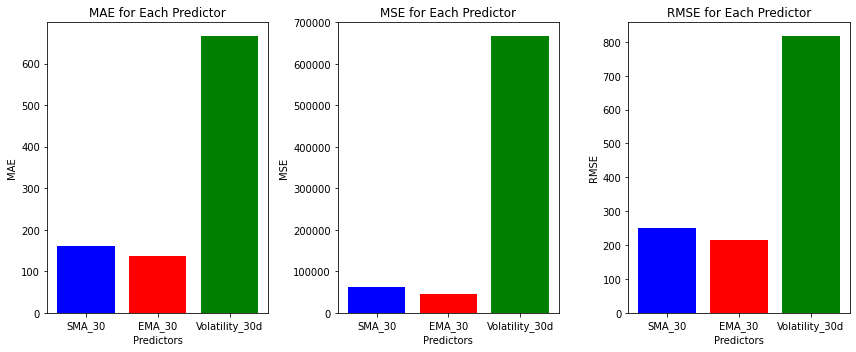

        Predictor         MAE            MSE        RMSE
0          SMA_30  161.101621   62447.436671  249.894851
1          EMA_30  137.152799   46388.575054  215.380071
2  Volatility_30d  665.827429  666866.014010  816.618647


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictors = ['SMA_30', 'EMA_30', 'Volatility_30d']
mae_scores = []
mse_scores = []
rmse_scores = []

for predictor in predictors:
    X = eth_stock[[predictor]]
    y = eth_stock['Close']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

error_df = pd.DataFrame({'Predictor': predictors, 'MAE': mae_scores, 'MSE': mse_scores, 'RMSE': rmse_scores})

# Plot the errors
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# MAE Bar Chart
ax[0].bar(error_df['Predictor'], error_df['MAE'], color=['blue', 'red', 'green'])
ax[0].set_title('MAE for Each Predictor')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Predictors')

# MSE Bar Chart
ax[1].bar(error_df['Predictor'], error_df['MSE'], color=['blue', 'red', 'green'])
ax[1].set_title('MSE for Each Predictor')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Predictors')

ax[2].bar(error_df['Predictor'], error_df['RMSE'], color=['blue', 'red', 'green'])
ax[2].set_title('RMSE for Each Predictor')
ax[2].set_ylabel('RMSE')
ax[2].set_xlabel('Predictors')

plt.tight_layout()
plt.show()

# Display the table
print(error_df)

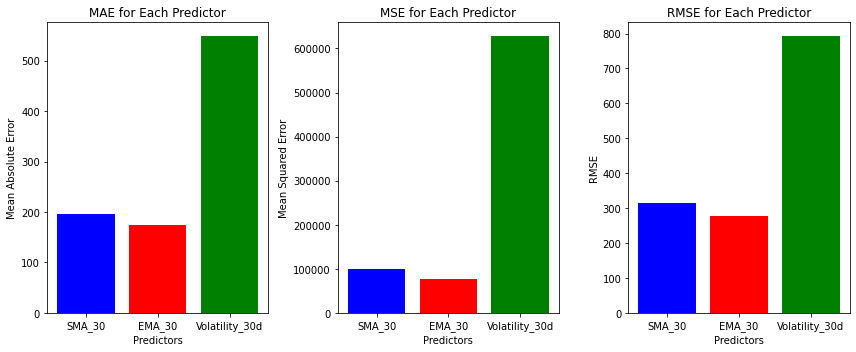

        Predictor         MAE            MSE        RMSE
0          SMA_30  195.153232   99451.935137  315.360009
1          EMA_30  174.947373   77801.015496  278.928334
2  Volatility_30d  548.379757  627815.346302  792.347996


In [34]:
# testing using random forest (next step is to test with the impurity parameter)

mae_scores = []
mse_scores = []
rmse_scores = []

for predictor in predictors:
    X = eth_stock[[predictor]]
    y = eth_stock['Close']
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    predictions = model.predict(X_test)
    
    # Calculate MAE & MSE
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    
    # Store results
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

# Convert results into a DataFrame
error_df = pd.DataFrame({'Predictor': predictors, 'MAE': mae_scores, 'MSE': mse_scores, 'RMSE': rmse_scores})

# Plot the errors
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# MAE Bar Chart
ax[0].bar(error_df['Predictor'], error_df['MAE'], color=['blue', 'red', 'green'])
ax[0].set_title('MAE for Each Predictor')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_xlabel('Predictors')

# MSE Bar Chart
ax[1].bar(error_df['Predictor'], error_df['MSE'], color=['blue', 'red', 'green'])
ax[1].set_title('MSE for Each Predictor')
ax[1].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('Predictors')

ax[2].bar(error_df['Predictor'], error_df['RMSE'], color=['blue', 'red', 'green'])
ax[2].set_title('RMSE for Each Predictor')
ax[2].set_ylabel('RMSE')
ax[2].set_xlabel('Predictors')

plt.tight_layout()
plt.show()

# Display the table
print(error_df)


In [8]:
# block chain data
block = pd.read_json("/Users/aaminathasneemkhaleel/Downloads/latest1K.json")
block.head()

,baseFeePerGas,difficulty,extraData,gasLimit,gasUsed,hash,logsBloom,miner,mixHash,nonce,...,sha3Uncles,size,stateRoot,timestamp,totalDifficulty,transactions,transactionsRoot,uncles,withdrawals,withdrawalsRoot
0,28250398000,0,0x406275696c64657230783639,30000000,10739924,0x7ccc3f05195b26f5c6810318057f49bffc131c2f296e...,0x1461605a494996481088082c911b402440214449ec80...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0x79d73eb8509f6c8b7f1b357fd342aa645666eeea7330...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,47293,0xa8e46aec3d0a50f69dbc2fb379b8176c59548fcddb60...,2023-05-21 02:58:35,5.875000e+22,[0x34efadbef9d09d3863caf60318922fe017d2b385c7a...,0x1720e999daeba3ae712f5782849ee16c8d6c43f36858...,[],"[{'index': '0x41ee2a', 'validatorIndex': '0x9b...",0xeacaa236f198b9a023e820c6626a6557bb5ab2de7e28...
1,27247490980,0,0x506f776572656420627920626c6f58726f757465,30000000,11533407,0xb261647b8b4f80841a578960080f34f5e79eb4173c33...,0x14b17443458215c81528b1f48a0c2420582ec5540a33...,0xf17d119effa0dcbe24d3fa346860be851150358f,0xa51c391172a60e5bb2344fdd413acd430fac6446ea72...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,158324,0x42208030c10c6d5dc13a90b6e3a19be3cacbe35a8ac6...,2023-05-21 02:58:47,5.875000e+22,[0xd14039be8a2f8c5146f231dbab8ff4665962b77f823...,0x055475da4288a7998776840a7761c07e015c3894e97c...,[],"[{'index': '0x41ee3a', 'validatorIndex': '0x9b...",0x848737a067209f01e194775e4cce68320794b43f3b84...
2,26460357968,0,0x7273796e632d6275696c6465722e78797a,30000000,10799859,0xdb70940f8b88d0ef7d7dc738476d9ed056bda2a09261...,0xc4630842510084ed5e082224f1504221512024120e91...,0x1f9090aae28b8a3dceadf281b0f12828e676c326,0xd87039c64393f58641e113883b9daa74713fed16ae5a...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,75547,0x8b37e1f779398ad391ab72aed50e74671939f4b01226...,2023-05-21 02:58:59,5.875000e+22,[0x45ace2431c66a08f7c66d4365a15463618685da4601...,0xd90b68fa3b513f84aab00b1c5dd36fbd0af15ba62e72...,[],"[{'index': '0x41ee4a', 'validatorIndex': '0x9b...",0x59efe39a3d25c592997450d70a42c6c00004e94a2c33...
3,25534214349,0,0x406275696c64657230783639,30000000,16701598,0x90171b4f643920bb9843555793254b62e1f154b22257...,0x132558d5cf769079d56e342c8a063ea1d7f501086414...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,0xe91777d1f5927e18e1c8117d85909fb7462af82007b0...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,68591,0xe8e0b2da89b3ad5a97dc027559c2a2569d695d9027f5...,2023-05-21 02:59:11,5.875000e+22,[0x6911109d64313afe782307b0d7e891000cf915ca209...,0x00af854f94c4a305ca9e2b9bc76bdc81cbac40c7ce16...,[],"[{'index': '0x41ee5a', 'validatorIndex': '0x9b...",0xf656e985a21358e644c72585d5606a60a12886f2ba75...
4,25896289082,0,0x496c6c756d696e61746520446d6f63726174697a6520...,30000000,13822589,0xef69c322fc2e149d26aa6f1dbc9fd0401aa681b6202a...,0x0ca108534b84458458685bf7c41425a048875c426ca4...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,0x6d51b333b142d8ba429ea037965606f36919de22ba79...,0x0000000000000000,...,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,59176,0xaac4782733c30ef11313e4630ab1b0e4e873950f9612...,2023-05-21 02:59:23,5.875000e+22,[0x148af8ff5beae7563b74d9d7f082cbb791f9abc83d1...,0xf3bddb69cfac0c19226404453fd797d0fffbfa559ae2...,[],"[{'index': '0x41ee6a', 'validatorIndex': '0x9b...",0x1851993d099c5fd4bc46904363bd277864de11b7ad3a...


In [9]:
block_clean= block.drop(columns=['difficulty', 'mixHash', 'nonce', 'sha3Uncles', 'totalDifficulty', 'uncles'])
block_clean.head()

,baseFeePerGas,extraData,gasLimit,gasUsed,hash,logsBloom,miner,number,parentHash,receiptsRoot,size,stateRoot,timestamp,transactions,transactionsRoot,withdrawals,withdrawalsRoot
0,28250398000,0x406275696c64657230783639,30000000,10739924,0x7ccc3f05195b26f5c6810318057f49bffc131c2f296e...,0x1461605a494996481088082c911b402440214449ec80...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,17304933,0xe4d2ac4f79d9c9c5cb924416611a0164adf1ff792914...,0x085c68912e3db339ea7d405411585faf1a6726f813cb...,47293,0xa8e46aec3d0a50f69dbc2fb379b8176c59548fcddb60...,2023-05-21 02:58:35,[0x34efadbef9d09d3863caf60318922fe017d2b385c7a...,0x1720e999daeba3ae712f5782849ee16c8d6c43f36858...,"[{'index': '0x41ee2a', 'validatorIndex': '0x9b...",0xeacaa236f198b9a023e820c6626a6557bb5ab2de7e28...
1,27247490980,0x506f776572656420627920626c6f58726f757465,30000000,11533407,0xb261647b8b4f80841a578960080f34f5e79eb4173c33...,0x14b17443458215c81528b1f48a0c2420582ec5540a33...,0xf17d119effa0dcbe24d3fa346860be851150358f,17304934,0x7ccc3f05195b26f5c6810318057f49bffc131c2f296e...,0xcebcc04faf2ca32f2514b6f922bb3ed39140795dcf85...,158324,0x42208030c10c6d5dc13a90b6e3a19be3cacbe35a8ac6...,2023-05-21 02:58:47,[0xd14039be8a2f8c5146f231dbab8ff4665962b77f823...,0x055475da4288a7998776840a7761c07e015c3894e97c...,"[{'index': '0x41ee3a', 'validatorIndex': '0x9b...",0x848737a067209f01e194775e4cce68320794b43f3b84...
2,26460357968,0x7273796e632d6275696c6465722e78797a,30000000,10799859,0xdb70940f8b88d0ef7d7dc738476d9ed056bda2a09261...,0xc4630842510084ed5e082224f1504221512024120e91...,0x1f9090aae28b8a3dceadf281b0f12828e676c326,17304935,0xb261647b8b4f80841a578960080f34f5e79eb4173c33...,0x9bcce037433076f78d0bcba7270226f4deb3f42328e4...,75547,0x8b37e1f779398ad391ab72aed50e74671939f4b01226...,2023-05-21 02:58:59,[0x45ace2431c66a08f7c66d4365a15463618685da4601...,0xd90b68fa3b513f84aab00b1c5dd36fbd0af15ba62e72...,"[{'index': '0x41ee4a', 'validatorIndex': '0x9b...",0x59efe39a3d25c592997450d70a42c6c00004e94a2c33...
3,25534214349,0x406275696c64657230783639,30000000,16701598,0x90171b4f643920bb9843555793254b62e1f154b22257...,0x132558d5cf769079d56e342c8a063ea1d7f501086414...,0x690b9a9e9aa1c9db991c7721a92d351db4fac990,17304936,0xdb70940f8b88d0ef7d7dc738476d9ed056bda2a09261...,0xac7cc201dcfc520457056252bd5a75ea39a1d081f022...,68591,0xe8e0b2da89b3ad5a97dc027559c2a2569d695d9027f5...,2023-05-21 02:59:11,[0x6911109d64313afe782307b0d7e891000cf915ca209...,0x00af854f94c4a305ca9e2b9bc76bdc81cbac40c7ce16...,"[{'index': '0x41ee5a', 'validatorIndex': '0x9b...",0xf656e985a21358e644c72585d5606a60a12886f2ba75...
4,25896289082,0x496c6c756d696e61746520446d6f63726174697a6520...,30000000,13822589,0xef69c322fc2e149d26aa6f1dbc9fd0401aa681b6202a...,0x0ca108534b84458458685bf7c41425a048875c426ca4...,0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5,17304937,0x90171b4f643920bb9843555793254b62e1f154b22257...,0x93b072cfd96198d77c15de5b98cb1c00721b9e4d7ae9...,59176,0xaac4782733c30ef11313e4630ab1b0e4e873950f9612...,2023-05-21 02:59:23,[0x148af8ff5beae7563b74d9d7f082cbb791f9abc83d1...,0xf3bddb69cfac0c19226404453fd797d0fffbfa559ae2...,"[{'index': '0x41ee6a', 'validatorIndex': '0x9b...",0x1851993d099c5fd4bc46904363bd277864de11b7ad3a...


In [10]:
transactions_list = []

for i, transactions in enumerate(block_clean['transactions']):
    # Check if there are transactions
    if len(transactions) > 0:
        for tx in transactions:
            transactions_list.append({
                'blockNumber': block_clean['number'][i],
                'transactionHash': tx
            })

# Create a DataFrame from the transactions list
transactions_df = pd.DataFrame(transactions_list)

# Optional: Print first few rows to check
transactions_df.head(100)

,blockNumber,transactionHash
0,17304933,0x34efadbef9d09d3863caf60318922fe017d2b385c7ac...
1,17304933,0x5ec9e8a88d8f6849ad0578cd9a9d14756971e581b7f1...
2,17304933,0xf03499d20ce740488712b368f4212da4d99b2d6394bf...
3,17304933,0x89b40131118e49dead97be37e01bb9c5b1190c69113d...
4,17304933,0x607d8710b9976ead4419e30e5cd63d6fec2b3ece98bf...
...,...,...
95,17304933,0xbf6b5c975efa18c012231d3d0e5f1f32939752f5f31c...
96,17304933,0x9a23abbe032cb4f992ed874cbfd79a3e770312ad2a0d...
97,17304933,0xc3076ac4e2d99d132e244760d5c2a8231fdd90900279...
98,17304933,0xa1b1d8078102a3d35d777680ce58ebf1ae9cda403c15...


In [6]:
# general validator details - notes from a prev meeting


import os
# import dask.dataframe as dd
import polars as pl
folder_path = "/Users/aaminathasneemkhaleel/Downloads/170-171-new"



In [7]:
json_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".json")]
data170_171=df = pl.concat([pl.read_json(file) for file in json_files], how="vertical")

ComputeError: can only deserialize json objects

In [ ]:
import os
import json
import polars as pl

def load_single_file(file_path):
    try:
        with open(file_path, 'r') as f:
            block = json.load(f)
            print(f"Loaded data from {file_path}")
            return block
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path}: {e}")

def process_file(file_path):
    block = load_single_file(file_path)
    if block:
        try:
            # Convert the block to Polars DataFrame with strict=False to allow mixed types
            df = pl.DataFrame([block], strict=False)
            print(df.head())
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

# Example
folder_path = "/Users/aaminathasneemkhaleel/Downloads/170-171-new"

df = load_blocks_polars(folder_path)

print(df.head())

In [8]:
# import os
# import json
# import polars as pl

# def load_single_file(file_path):
#     try:
#         with open(file_path, 'r') as f:
#             block = json.load(f)
#             print(f"Loaded data from {file_path}")
#             return block
#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON in {file_path}: {e}")
#     except Exception as e:
#         print(f"Unexpected error with {file_path}: {e}")

# def process_file(file_path):
#     block = pd.read_json(load_single_file(file_path))
#     if block:
#         # Convert the block to Polars DataFrame
#         df_polars = pl.from_pandas(block)
#         #df = pl.DataFrame([block], strict=False)
#         print(df.head())

# # Example: Process one file at a time
# folder_path = "/Users/aaminathasneemkhaleel/Downloads/170-171-new"
# file_to_process = os.path.join(folder_path, "blockTransactions17010001-17011000.json")

# process_file(file_to_process)

import os
import json
import polars as pl
import pandas as pd  # Make sure you import pandas

def load_single_file(file_path):
    try:
        with open(file_path, 'r') as f:
            block = json.load(f)
            print(f"Loaded data from {file_path}")
            return block
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path}: {e}")

def process_file(file_path):
    block = load_single_file(file_path)  # Directly get the parsed data
    if block:
        # Convert the block to a pandas DataFrame
        df = pd.DataFrame(block)
        
        # Convert pandas DataFrame to Polars DataFrame
        df_polars = pl.from_pandas(df)
        
        # Print the first few rows of the Polars DataFrame
        print(df_polars.head())

# Example: Process one file at a time
folder_path = "/Users/aaminathasneemkhaleel/Downloads/170-171-new"
file_to_process = os.path.join(folder_path, "blockTransactions17010001-17011000.json")

process_file(file_to_process)


Loaded data from /Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17010001-17011000.json
shape: (5, 530)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ 0       ┆ 1       ┆ 2       ┆ 3      ┆ … ┆ 526    ┆ 527    ┆ 528    ┆ 529    │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ struct[ ┆ struct[ ┆ struct[ ┆ struct ┆   ┆ struct ┆ struct ┆ struct ┆ struct │
│ 21]     ┆ 19]     ┆ 19]     ┆ [19]   ┆   ┆ [19]   ┆ [19]   ┆ [19]   ┆ [19]   │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ {"22127 ┆ {null," ┆ {null," ┆ {null, ┆ … ┆ null   ┆ null   ┆ null   ┆ null   │
│ 255676" ┆ 0x3b075 ┆ 0x3b075 ┆ "0x3b0 ┆   ┆        ┆        ┆        ┆        │
│ ,"0","0 ┆ 7b9a222 ┆ 7b9a222 ┆ 757b9a ┆   ┆        ┆        ┆        ┆        │
│ xd88301 ┆ 00856fc ┆ 00856fc ┆ 222008 ┆   ┆        ┆        ┆        ┆        │
│ 0b…     ┆ 04…     ┆ 04…     ┆ 56fc04 ┆   ┆        ┆        ┆    

In [ ]:
import os
import json
import polars as pl
import pandas as pd

def load_single_file(file_path):
    try:
        with open(file_path, 'r') as f:
            block = json.load(f)
            print(f"Loaded data from {file_path}")
            return block
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path}: {e}")

def process_file(file_path):
    block = load_single_file(file_path)  # Directly get the parsed data
    if block:
        # Convert the block to a pandas DataFrame
        df = pd.DataFrame(block)
        
        # Convert pandas DataFrame to Polars DataFrame
        df_polars = pl.from_pandas(df)
        
        # Print the first few rows of the Polars DataFrame
        print(df_polars.head())

def process_all_files_in_folder(folder_path):
    # List all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if the file is a JSON file
        if filename.endswith('.json'):
            print(f"Processing file: {filename}")
            process_file(file_path)

# Example: Process all JSON files in the folder
folder_path = "/Users/aaminathasneemkhaleel/Downloads/170-171-new"
process_all_files_in_folder(folder_path)


In [16]:
# with open(file_to_process, 'r') as f:
#     for i in range(100):
#         print(f.readline())

import json

with open(file_to_process, 'r') as f:
    data = f.read()
    try:
        json.loads(data)
        print("Valid JSON")
    except json.JSONDecodeError as e:
        print(f"JSON error: {e}")

JSON error: Expecting value: line 23053170 column 1 (char 2326186313)


In [27]:
import polars as pl
import pandas as pd
block = pd.read_json("/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17011001-17012000.json")
df_polars = pl.from_pandas(block)
print(df_polars.head())

shape: (5, 461)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ 0       ┆ 1       ┆ 2       ┆ 3      ┆ … ┆ 457    ┆ 458    ┆ 459    ┆ 460    │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ struct[ ┆ struct[ ┆ struct[ ┆ struct ┆   ┆ struct ┆ struct ┆ struct ┆ struct │
│ 21]     ┆ 19]     ┆ 19]     ┆ [19]   ┆   ┆ [19]   ┆ [19]   ┆ [19]   ┆ [19]   │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ {"22619 ┆ {null," ┆ {[],"0x ┆ {[],"0 ┆ … ┆ null   ┆ null   ┆ null   ┆ null   │
│ 805910" ┆ 0x38255 ┆ 38255d9 ┆ x38255 ┆   ┆        ┆        ┆        ┆        │
│ ,"0","0 ┆ d9683c0 ┆ 683c0f6 ┆ d9683c ┆   ┆        ┆        ┆        ┆        │
│ x546974 ┆ f607040 ┆ 07040d7 ┆ 0f6070 ┆   ┆        ┆        ┆        ┆        │
│ 61…     ┆ d7…     ┆ 5c…     ┆ 40d75c ┆   ┆        ┆        ┆        ┆        │
│         ┆         ┆         ┆ …      ┆   ┆        ┆        ┆        ┆        │
│ {"22452 ┆ 

In [25]:
print(block.head())
print(type(block))          # list? dict?
print(type(block[0][0]))       # list? dict?
print(type(block[0][1]))
print(block[390])             # peek into first item
#print(block.head())
print(len(block))

                                                 0    \
0  {'baseFeePerGas': '22619805910', 'difficulty':...   
1  {'baseFeePerGas': '22452767692', 'difficulty':...   
2  {'baseFeePerGas': '21965792046', 'difficulty':...   
3  {'baseFeePerGas': '21874185907', 'difficulty':...   
4  {'baseFeePerGas': '22565774386', 'difficulty':...   

                                                 1    \
0  {'blockHash': '0x38255d9683c0f607040d75cfbaacf...   
1  {'blockHash': '0xd128c94cb80c9ba13f96841a361b7...   
2  {'blockHash': '0x4e76e60a9d0fa4f366f42b271d3e3...   
3  {'blockHash': '0xb92784f6f43bcf6377054805b1a1b...   
4  {'blockHash': '0xc29c21ed7dafba1d8ba9d22181655...   

                                                 2    \
0  {'blockHash': '0x38255d9683c0f607040d75cfbaacf...   
1  {'blockHash': '0xd128c94cb80c9ba13f96841a361b7...   
2  {'blockHash': '0x4e76e60a9d0fa4f366f42b271d3e3...   
3  {'blockHash': '0xb92784f6f43bcf6377054805b1a1b...   
4  {'blockHash': '0xc29c21ed7dafba1d8ba9d22181

In [15]:
flattened = pd.json_normalize(block[2])


# Optional: check columns
print(flattened.columns)

# Now you can use it like a normal DataFrame
print(flattened.head())


# Index(['baseFeePerGas', 'difficulty', 'extraData', 'gasLimit', 'gasUsed',
#        'hash', 'logsBloom', 'miner', 'mixHash', 'nonce', 'number',
#        'parentHash', 'receiptsRoot', 'sha3Uncles', 'size', 'stateRoot',
#        'timestamp', 'totalDifficulty', 'transactions', 'transactionsRoot',
#        'uncles'],
#       dtype='object')

# Index(['blockHash', 'blockNumber', 'from', 'gas', 'gasPrice', 'hash', 'input',
#        'nonce', 'to', 'transactionIndex', 'value', 'type', 'chainId', 'v', 'r',
#        's', 'maxFeePerGas', 'maxPriorityFeePerGas', 'accessList'],
#       dtype='object')


# Index(['blockHash', 'blockNumber', 'from', 'gas', 'gasPrice', 'hash', 'input',
#        'nonce', 'to', 'transactionIndex', 'value', 'type', 'chainId', 'v', 'r',
#        's', 'maxFeePerGas', 'maxPriorityFeePerGas', 'accessList'],
#       dtype='object')

Index(['blockHash', 'blockNumber', 'from', 'gas', 'gasPrice', 'maxFeePerGas',
       'maxPriorityFeePerGas', 'hash', 'input', 'nonce', 'to',
       'transactionIndex', 'value', 'type', 'accessList', 'chainId', 'v', 'r',
       's'],
      dtype='object')
                                           blockHash  blockNumber  \
0  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...   17011001.0   
1  0xd128c94cb80c9ba13f96841a361b75ea9e3de646483b...   17011002.0   
2  0x4e76e60a9d0fa4f366f42b271d3e3181f1b666923051...   17011003.0   
3  0xb92784f6f43bcf6377054805b1a1bc24e93250fa8f40...   17011004.0   
4  0xc29c21ed7dafba1d8ba9d22181655206ca710d9277b6...   17011005.0   

                                         from        gas     gasPrice  \
0  0x2e37ff4738c76da648cbb451964340047252b633    21000.0  72569805910   
1  0x86cc605368bd7924953625359f4bff3bd38fcf63   300000.0  73000000000   
2  0xae8e3c8275b1d63da42acde88b3449e7a69442b7   448105.0  23965792046   
3  0xf58ceabac596ceadd98ca4c0b74ef4d3a

In [18]:
#transactions = [pd.json_normalize(tx) for tx in block[1:]]
transactions = pd.json_normalize(block[1:])
print(transactions.head())

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [24]:
# df_transactions = pd.DataFrame(block[1:])
# print(df_transactions.head())
# print(df_transactions.columns)

tx_data = [tx[1] for tx in block[1:] if isinstance(tx, list) and len(tx) > 1]
df_transactions = pd.DataFrame(tx_data)
print(df_transactions.head())

Empty DataFrame
Columns: []
Index: []


In [12]:
first_row = block.iloc[0]  # This will give the first row of the DataFrame
print(first_row)

0      {'baseFeePerGas': '22619805910', 'difficulty':...
1      {'blockHash': '0x38255d9683c0f607040d75cfbaacf...
2      {'blockHash': '0x38255d9683c0f607040d75cfbaacf...
3      {'blockHash': '0x38255d9683c0f607040d75cfbaacf...
4      {'blockHash': '0x38255d9683c0f607040d75cfbaacf...
                             ...                        
456                                                 None
457                                                 None
458                                                 None
459                                                 None
460                                                 None
Name: 0, Length: 461, dtype: object


In [122]:
# i know i have a lot, but essentially, the first row contains block level details like gasLimit, transactionRoot, miner, etc.
# but blocks 1-453 are transaction data
# first convert block level, then to polars
block_level = pd.json_normalize(block[0])
# print(block_level.columns)
# print(block_level.head())
df_polars = pl.from_pandas(block_level)
print(df_polars.head())
print(df_polars.columns)


shape: (5, 21)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ baseFee ┆ difficu ┆ extraDa ┆ gasLim ┆ … ┆ totalD ┆ transa ┆ transa ┆ uncles │
│ PerGas  ┆ lty     ┆ ta      ┆ it     ┆   ┆ ifficu ┆ ctions ┆ ctions ┆ ---    │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ lty    ┆ ---    ┆ Root   ┆ list[n │
│ str     ┆ str     ┆ str     ┆ i64    ┆   ┆ ---    ┆ list[s ┆ ---    ┆ ull]   │
│         ┆         ┆         ┆        ┆   ┆ str    ┆ tr]    ┆ str    ┆        │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 2261980 ┆ 0       ┆ 0x54697 ┆ 300000 ┆ … ┆ 5.8750 ┆ ["0xd7 ┆ 0x2d03 ┆ []     │
│ 5910    ┆         ┆ 4616e   ┆ 00     ┆   ┆ 003716 ┆ 0880ba ┆ f8ebcf ┆        │
│         ┆         ┆         ┆        ┆   ┆ 598352 ┆ 7a1106 ┆ 08ee48 ┆        │
│         ┆         ┆         ┆        ┆   ┆ 816469 ┆ 6cef95 ┆ 087963 ┆        │
│         ┆         ┆         ┆        ┆   ┆ e+22   ┆ a16956 ┆ 451284 ┆        │
│         ┆  

In [121]:
#now we will create the transactions table which is blocks 1-453
# transactions = pd.json_normalize(block[1]) works but the one below does not
# transactions = pd.json_normalize(block[1:])
#print(block[1:])
transactions =[] 
for i in block[1]:
    transactions.append(pd.json_normalize(i))

    
#pd.concat([pd.json_normalize(item) for item in block[1:]], ignore_index=True)

#print(transactions.columns)
#df_transactions= pl.from_pandas(transactions)
#print(df_transactions)

NotImplementedError: 

In [59]:
print(block.head())

                                                 0    \
0  {'baseFeePerGas': '22619805910', 'difficulty':...   
1  {'baseFeePerGas': '22452767692', 'difficulty':...   
2  {'baseFeePerGas': '21965792046', 'difficulty':...   
3  {'baseFeePerGas': '21874185907', 'difficulty':...   
4  {'baseFeePerGas': '22565774386', 'difficulty':...   

                                                 1    \
0  {'blockHash': '0x38255d9683c0f607040d75cfbaacf...   
1  {'blockHash': '0xd128c94cb80c9ba13f96841a361b7...   
2  {'blockHash': '0x4e76e60a9d0fa4f366f42b271d3e3...   
3  {'blockHash': '0xb92784f6f43bcf6377054805b1a1b...   
4  {'blockHash': '0xc29c21ed7dafba1d8ba9d22181655...   

                                                 2    \
0  {'blockHash': '0x38255d9683c0f607040d75cfbaacf...   
1  {'blockHash': '0xd128c94cb80c9ba13f96841a361b7...   
2  {'blockHash': '0x4e76e60a9d0fa4f366f42b271d3e3...   
3  {'blockHash': '0xb92784f6f43bcf6377054805b1a1b...   
4  {'blockHash': '0xc29c21ed7dafba1d8ba9d22181

In [7]:
print(df_polars.head())

shape: (5, 530)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ 0       ┆ 1       ┆ 2       ┆ 3      ┆ … ┆ 526    ┆ 527    ┆ 528    ┆ 529    │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ struct[ ┆ struct[ ┆ struct[ ┆ struct ┆   ┆ struct ┆ struct ┆ struct ┆ struct │
│ 21]     ┆ 19]     ┆ 19]     ┆ [19]   ┆   ┆ [19]   ┆ [19]   ┆ [19]   ┆ [19]   │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ {"22127 ┆ {null," ┆ {null," ┆ {null, ┆ … ┆ null   ┆ null   ┆ null   ┆ null   │
│ 255676" ┆ 0x3b075 ┆ 0x3b075 ┆ "0x3b0 ┆   ┆        ┆        ┆        ┆        │
│ ,"0","0 ┆ 7b9a222 ┆ 7b9a222 ┆ 757b9a ┆   ┆        ┆        ┆        ┆        │
│ xd88301 ┆ 00856fc ┆ 00856fc ┆ 222008 ┆   ┆        ┆        ┆        ┆        │
│ 0b…     ┆ 04…     ┆ 04…     ┆ 56fc04 ┆   ┆        ┆        ┆        ┆        │
│         ┆         ┆         ┆ …      ┆   ┆        ┆        ┆        ┆        │
│ {"20928 ┆ 

In [64]:
# I am trying rong's methd using json load
with open("/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17011001-17012000.json", 'r') as file:
  data = json.load(file)

processed_data = []
for obj in data:
    if not obj:
        continue  # Skip empty objects
    first_dict = obj[0]
    rest = obj[1:]
    first_dict["transactions_list"] = rest
    processed_data.append(first_dict)
    
df_test= pd.DataFrame(processed_data)

transaction_records = []

for idx, transactions in df_test['transactions_list'].items():
    for tx in transactions:
        tx_row = {col: tx.get(col, np.nan) for col in expected_columns}
        # Optionally, add index of the original row for reference
        tx_row['original_df_index'] = idx
        transaction_records.append(tx_row)

       
transactions_df = pd.DataFrame(transaction_records)
transactions_test = pl.from_pandas(transactions_df)

df_test = df_test.drop(columns=['transactions_list','difficulty', 'mixHash', 'nonce', 'sha3Uncles', 'totalDifficulty', 'uncles'])


df_block_level = pl.from_pandas(df_test)
print(df_block_level.head())

print(transactions_test.head())

#the commented code was for initial testing, but we want to increase the efficiency so we reduced the number of extra copies of data
# transactions_df = df_test[['transactions_list']].copy()

# Create a DataFrame with all other columns excluding 'transactions_list'
# params_df = df_test.drop(columns=['transactions_list']).copy()

#df_block_level = pl.from_pandas(params_df)
# print(df_block_level.head())

# df_block_level = pl.from_pandas(df_test)
# print(df_block_level.head())

# transactions_test = pl.from_pandas(transactions_df)











shape: (5, 15)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ baseFee ┆ extraDa ┆ gasLimi ┆ gasUse ┆ … ┆ stateR ┆ timest ┆ transa ┆ transa │
│ PerGas  ┆ ta      ┆ t       ┆ d      ┆   ┆ oot    ┆ amp    ┆ ctions ┆ ctions │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ Root   │
│ str     ┆ str     ┆ i64     ┆ i64    ┆   ┆ str    ┆ i64    ┆ list[s ┆ ---    │
│         ┆         ┆         ┆        ┆   ┆        ┆        ┆ tr]    ┆ str    │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 2261980 ┆ 0x54697 ┆ 3000000 ┆ 141138 ┆ … ┆ 0xe7da ┆ 168104 ┆ ["0xd7 ┆ 0x2d03 │
│ 5910    ┆ 4616e   ┆ 0       ┆ 48     ┆   ┆ effb4c ┆ 6459   ┆ 0880ba ┆ f8ebcf │
│         ┆         ┆         ┆        ┆   ┆ 8c80ab ┆        ┆ 7a1106 ┆ 08ee48 │
│         ┆         ┆         ┆        ┆   ┆ 28ba1c ┆        ┆ 6cef95 ┆ 087963 │
│         ┆         ┆         ┆        ┆   ┆ 0de72a ┆        ┆ a16956 ┆ 451284 │
│         ┆  

In [31]:
df_test= pd.DataFrame(processed_data)
print(df_test.head())

  baseFeePerGas difficulty                                          extraData  \
0   22619805910          0                                       0x546974616e   
1   22452767692          0  0xd883010b05846765746888676f312e32302e32856c69...   
2   21965792046          0                           0x6275696c64657230783639   
3   21874185907          0                     0x6279206275696c64657230783639   
4   22565774386          0                                       0x546974616e   

   gasLimit   gasUsed                                               hash  \
0  30000000  14113848  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...   
1  30000000  12397333  0xd128c94cb80c9ba13f96841a361b75ea9e3de646483b...   
2  30000000  14499552  0x4e76e60a9d0fa4f366f42b271d3e3181f1b666923051...   
3  30000000  18793998  0xb92784f6f43bcf6377054805b1a1bc24e93250fa8f40...   
4  30000000  10179019  0xc29c21ed7dafba1d8ba9d22181655206ca710d9277b6...   

                                           logsBloom  \


In [55]:
transactions_df = df_test[['transactions_list']].copy()

# Create a DataFrame with all other columns excluding 'transactions_list'
params_df = df_test.drop(columns=['transactions_list']).copy()

In [56]:
print(transactions_df.head())

                                   transactions_list
0  [{'blockHash': '0x38255d9683c0f607040d75cfbaac...
1  [{'blockHash': '0xd128c94cb80c9ba13f96841a361b...
2  [{'blockHash': '0x4e76e60a9d0fa4f366f42b271d3e...
3  [{'blockHash': '0xb92784f6f43bcf6377054805b1a1...
4  [{'blockHash': '0xc29c21ed7dafba1d8ba9d2218165...


In [57]:
df_block_level = pl.from_pandas(params_df)
print(df_block_level.head())

df_transactions = pl.from_pandas(transactions_df)
print(df_transactions.head())

shape: (5, 21)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ baseFee ┆ difficu ┆ extraDa ┆ gasLim ┆ … ┆ totalD ┆ transa ┆ transa ┆ uncles │
│ PerGas  ┆ lty     ┆ ta      ┆ it     ┆   ┆ ifficu ┆ ctions ┆ ctions ┆ ---    │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ lty    ┆ ---    ┆ Root   ┆ list[n │
│ str     ┆ str     ┆ str     ┆ i64    ┆   ┆ ---    ┆ list[s ┆ ---    ┆ ull]   │
│         ┆         ┆         ┆        ┆   ┆ str    ┆ tr]    ┆ str    ┆        │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 2261980 ┆ 0       ┆ 0x54697 ┆ 300000 ┆ … ┆ 5.8750 ┆ ["0xd7 ┆ 0x2d03 ┆ []     │
│ 5910    ┆         ┆ 4616e   ┆ 00     ┆   ┆ 003716 ┆ 0880ba ┆ f8ebcf ┆        │
│         ┆         ┆         ┆        ┆   ┆ 598352 ┆ 7a1106 ┆ 08ee48 ┆        │
│         ┆         ┆         ┆        ┆   ┆ 816469 ┆ 6cef95 ┆ 087963 ┆        │
│         ┆         ┆         ┆        ┆   ┆ e+22   ┆ a16956 ┆ 451284 ┆        │
│         ┆  

In [58]:
expected_columns = [
    'blockHash', 'blockNumber', 'from', 'gas', 'gasPrice',
    'hash', 'input', 'nonce', 'to', 'transactionIndex', 'value', 'type',
    'chainId', 'v', 'r', 's', 'maxPriorityFeePerGas', 'accessList', 'maxFeePerGas'
]

transaction_records = []

for idx, transactions in df_test['transactions_list'].items():
    for tx in transactions:
        tx_row = {col: tx.get(col, np.nan) for col in expected_columns}
        # Optionally, add index of the original row for reference
        tx_row['original_df_index'] = idx
        transaction_records.append(tx_row)

transactions_df = pd.DataFrame(transaction_records)
print(transactions_df.head())

# issues with this --> the polars df is empty
# flattened = pd.json_normalize(transactions_df)
# df_polars = pl.from_pandas(flattened)
# print(df_polars.head())

                                           blockHash  blockNumber  \
0  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...     17011001   
1  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...     17011001   
2  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...     17011001   
3  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...     17011001   
4  0x38255d9683c0f607040d75cfbaacf39f8377082d0892...     17011001   

                                         from      gas     gasPrice  \
0  0xe93685f3bba03016f02bd1828badd6195988d950  4563608  30165056757   
1  0x2e37ff4738c76da648cbb451964340047252b633    21000  72569805910   
2  0xf2e9bf60d65d2e66916093d81fa736c215dfdf95    21000  72569805910   
3  0x18ed4b66b380f2853ba991b298a2574d0667ef0a    21000  72569805910   
4  0x512f92d15cd7af9bbd6d630ce6a34be4537de664    21000  72569805910   

                                                hash  \
0  0xd70880ba7a11066cef95a16956c5b958b1782d5fb20e...   
1  0xe2bfafd85ee0d34c0c431bc17cc13163d632179ce

In [59]:
transactions_test = pl.from_pandas(transactions_df)
# polars_transactions = pl.from_pandas(transactions_test)

print(transactions_test.head())

shape: (5, 20)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ blockHa ┆ blockNu ┆ from    ┆ gas    ┆ … ┆ maxPri ┆ access ┆ maxFee ┆ origin │
│ sh      ┆ mber    ┆ ---     ┆ ---    ┆   ┆ orityF ┆ List   ┆ PerGas ┆ al_df_ │
│ ---     ┆ ---     ┆ str     ┆ i64    ┆   ┆ eePerG ┆ ---    ┆ ---    ┆ index  │
│ str     ┆ i64     ┆         ┆        ┆   ┆ as     ┆ list[s ┆ str    ┆ ---    │
│         ┆         ┆         ┆        ┆   ┆ ---    ┆ truct[ ┆        ┆ i64    │
│         ┆         ┆         ┆        ┆   ┆ str    ┆ 2]]    ┆        ┆        │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 0x38255 ┆ 1701100 ┆ 0xe9368 ┆ 456360 ┆ … ┆ null   ┆ null   ┆ null   ┆ 0      │
│ d9683c0 ┆ 1       ┆ 5f3bba0 ┆ 8      ┆   ┆        ┆        ┆        ┆        │
│ f607040 ┆         ┆ 3016f02 ┆        ┆   ┆        ┆        ┆        ┆        │
│ d75cfba ┆         ┆ bd1828b ┆        ┆   ┆        ┆        ┆        ┆        │
│ ac…     ┆  

In [49]:
print(transaction_records[1])
#print(transaction_records[:10])


{'blockHash': '0x38255d9683c0f607040d75cfbaacf39f8377082d0892c86d5327b97cafc823a6', 'blockNumber': 17011001, 'from': '0x2e37ff4738c76da648cbb451964340047252b633', 'gas': 21000, 'gasPrice': '72569805910', 'hash': '0xe2bfafd85ee0d34c0c431bc17cc13163d632179ce33972d0e9ad42d134e120b0', 'input': '0x', 'nonce': 72, 'to': '0x2e37ff4738c76da648cbb451964340047252b633', 'transactionIndex': 1, 'value': '0', 'type': '0x2', 'chainId': '0x1', 'v': '0x0', 'r': '0x7b06f702153c4b8b42d9c40a022c4d61d6bb163f5180ea3c18e8ee67d02119c5', 's': '0x45bf8d83157545d95f5d5ed6d164982f396b01375dfefc8b0989f803805180c2', 'maxPriorityFeePerGas': '49950000000', 'accessList': [], 'maxFeePerGas': '74535169704', 'original_df_index': 0}


In [10]:
ether_supply = pd.read_csv("/Users/aaminathasneemkhaleel/Downloads/Ethersupply2.csv")
ether_supply.head()

,Date(UTC),UnixTimeStamp,Value
0,7/30/2015,1438214400,7.204931e+07
1,7/31/2015,1438300800,7.208550e+07
2,8/1/2015,1438387200,7.211320e+07
3,8/2/2015,1438473600,7.214143e+07
4,8/3/2015,1438560000,7.216940e+07
